In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report
import lightgbm as lgb

# path
path_dir = 'C:/Users/USER/.kaggle/competitions/ieee-fraud-detection/'
file_list = os.listdir(path_dir)
file_list

['sample_submission.csv',
 'test_identity.csv',
 'test_transaction.csv',
 'train_identity.csv',
 'train_transaction.csv']

## Load Data

In [31]:
# Train Data
train_identity = pd.read_csv(path_dir+'train_identity.csv')
train_transaction = pd.read_csv(path_dir+'train_transaction.csv')
# Test Data
test_identity = pd.read_csv(path_dir+'test_identity.csv')
test_transaction = pd.read_csv(path_dir+'test_transaction.csv')

In [32]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [33]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Merge

In [34]:
train_merge = pd.merge(train_identity, train_transaction, on=['TransactionID'], how='right')
test_merge = pd.merge(test_identity, test_transaction, on=['TransactionID'], how='right')

del train_identity, train_transaction, test_identity, test_transaction

In [35]:
train_merge.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Check NULL ratio >= 0.8
check_null = train_merge.isna().sum() / len(train_merge)
check_null[check_null >= 0.8]

id_03    0.887689
id_04    0.887689
id_07    0.991271
id_08    0.991271
id_09    0.873123
           ...   
V335     0.860550
V336     0.860550
V337     0.860550
V338     0.860550
V339     0.860550
Length: 74, dtype: float64

In [37]:
# remove cols of null ratio >= 0.8
remove_cols = check_null[check_null >= 0.8].keys()

train_merge = train_merge.drop(remove_cols, axis=1)
test_merge = test_merge.drop(remove_cols, axis=1)
print(train_merge.shape)
print(test_merge.shape)

(590540, 360)
(506691, 359)


In [44]:
train_merge.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,NaN,New,NotFound,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,49.0,New,NotFound,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,52.0,Found,Found,...,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,52.0,New,NotFound,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,NaN,Found,Found,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [45]:
# select types
object_cols = train_merge.select_dtypes(include='object').columns
nobject_cols = train_merge.select_dtypes(exclude='object').columns

print('Columns of Object Type\n{}'.format(object_cols.values))

Columns of Object Type
['id_12' 'id_15' 'id_16' 'id_28' 'id_29' 'id_31' 'id_35' 'id_36' 'id_37'
 'id_38' 'DeviceType' 'DeviceInfo' 'ProductCD' 'card4' 'card6'
 'P_emaildomain' 'R_emaildomain' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8'
 'M9']


In [46]:
train_merge[object_cols] = train_merge[object_cols].fillna('NaN')
train_merge[nobject_cols] = train_merge[nobject_cols].fillna(0)

test_merge[object_cols] = test_merge[object_cols].fillna('NaN')
nobject_cols = list(nobject_cols)
nobject_cols.remove('isFraud')
test_merge[nobject_cols] = test_merge[nobject_cols].fillna(0)

In [47]:
train_merge.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987004,0.0,70787.0,0.0,0.0,100.0,NotFound,0.0,New,NotFound,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,49.0,New,NotFound,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,52.0,Found,Found,...,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,52.0,New,NotFound,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,0.0,Found,Found,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


## EDA

#### isFraud

Ratio of isFraud 0 : 96.5 %
Ratio of isFraud 1 : 3.5 %


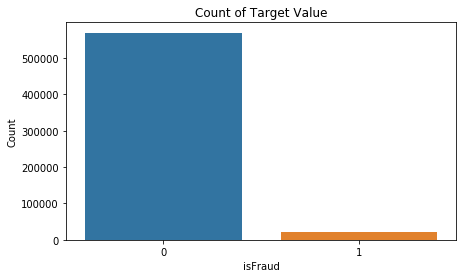

In [48]:
# Ratio of isFraud(target value)
isfraud_values = train_merge['isFraud'].value_counts().values
isfraud_0 = (isfraud_values[0] / len(train_merge['isFraud'])) * 100
isfraud_1 = (isfraud_values[1] / len(train_merge['isFraud'])) * 100
print('Ratio of isFraud 0 : {:.1f} %'.format(isfraud_0))
print('Ratio of isFraud 1 : {:.1f} %'.format(isfraud_1))

# plot
plt.figure(figsize=(7, 4))
sns.countplot(x='isFraud', data=train_merge)
plt.xlabel('isFraud'); plt.ylabel('Count')
plt.title('Count of Target Value'); plt.show()

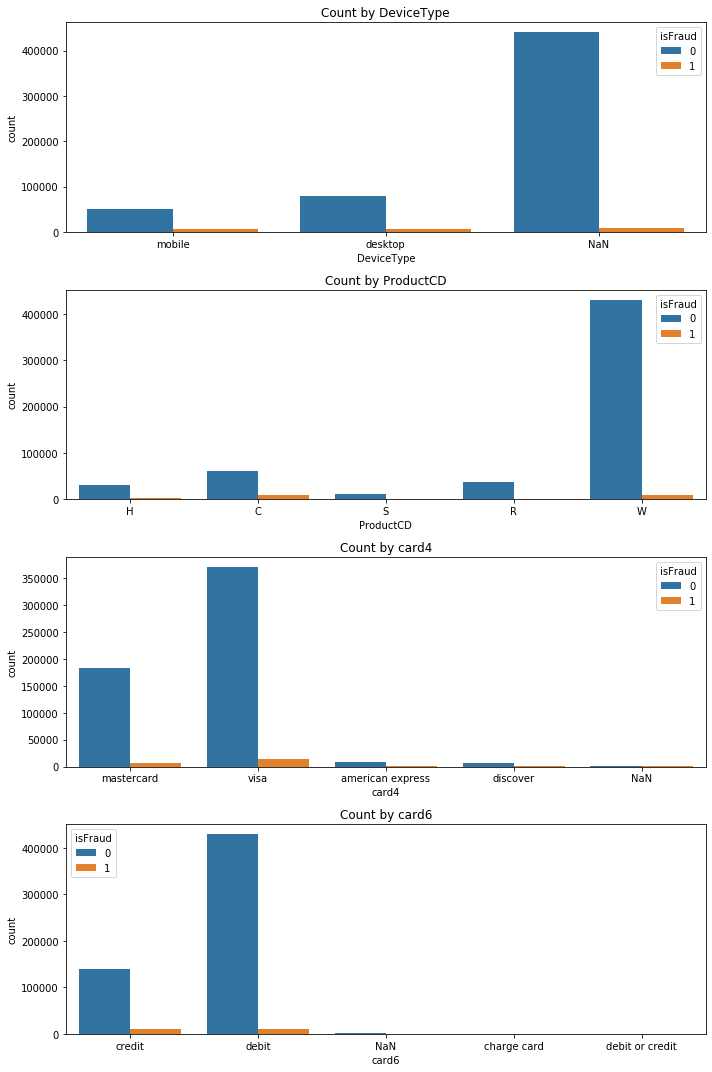

In [49]:
cols = ['DeviceType', 'ProductCD', 'card4', 'card6']
plt.figure(figsize=(10, 15))
for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i+1)
    sns.countplot(x=col,  hue='isFraud', data=train_merge)
    plt.title('Count by '+str(col))
    plt.tight_layout()

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


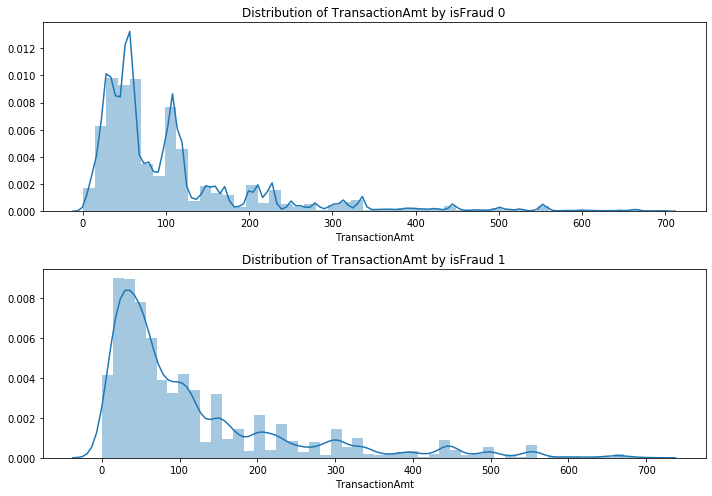

In [50]:
# Distribution of TransactionAmt by isFraud
plt.figure(figsize=(10, 7))
for i in [0, 1]:
    plt.subplot(2,1, i+1)
    sns.distplot(train_merge[train_merge['isFraud'] == i][train_merge['TransactionAmt'] <=700]['TransactionAmt'])
    plt.title('Distribution of TransactionAmt by isFraud '+str(i))
    plt.tight_layout()

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


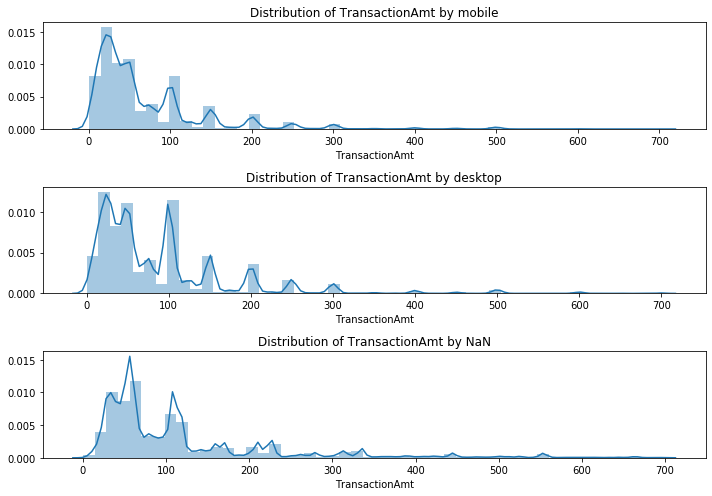

In [51]:
# Distribution of TransactionAmt by DeviceType
devicetype = train_merge['DeviceType'].unique()
plt.figure(figsize=(10, 7))
for i, device in enumerate(devicetype):
    plt.subplot(len(devicetype), 1, i+1)
    sns.distplot(train_merge[train_merge['DeviceType'] == device][train_merge['TransactionAmt'] <=700]['TransactionAmt'])
    plt.title('Distribution of TransactionAmt by '+str(device))
    plt.tight_layout()

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


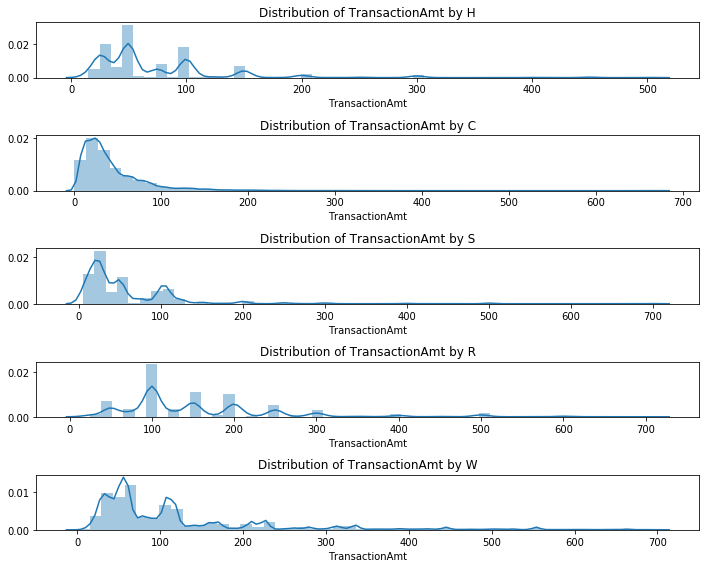

In [52]:
productcd = train_merge['ProductCD'].unique()
plt.figure(figsize=(10, 8))
for i, cd in enumerate(productcd):
    plt.subplot(len(productcd), 1, i+1)
    sns.distplot(train_merge[train_merge['ProductCD']==cd][train_merge['TransactionAmt'] <=700]['TransactionAmt'])
    plt.title('Distribution of TransactionAmt by '+str(cd))
    plt.tight_layout()

## Data Preprocessing

#### Data Simplication
- mobile os / browers / email domain

In [53]:
# unique한 특성이 너무 많아 데이터 단순화 필요 
# print('id_30 : {}'.format(train_merge['id_30'].unique())+'\n')
print('id_31 : {}'.format(train_merge['id_31'].unique())+'\n')
print('P_emaildomain : {}'.format(train_merge['P_emaildomain'].unique())+'\n')
print('R_emaildomain : {}'.format(train_merge['R_emaildomain'].unique())+'\n')

id_31 : ['samsung browser 6.2' 'mobile safari 11.0' 'chrome 62.0' 'NaN'
 'chrome 62.0 for android' 'edge 15.0' 'mobile safari generic'
 'chrome 49.0' 'chrome 61.0' 'edge 16.0' 'safari generic' 'edge 14.0'
 'chrome 56.0 for android' 'firefox 57.0' 'chrome 54.0 for android'
 'mobile safari uiwebview' 'chrome' 'chrome 62.0 for ios' 'firefox'
 'chrome 60.0 for android' 'mobile safari 10.0' 'chrome 61.0 for android'
 'ie 11.0 for desktop' 'ie 11.0 for tablet' 'mobile safari 9.0'
 'chrome generic' 'other' 'chrome 59.0 for android' 'firefox 56.0'
 'android webview 4.0' 'chrome 55.0' 'opera 49.0' 'ie'
 'chrome 55.0 for android' 'firefox 52.0' 'chrome 57.0 for android'
 'chrome 56.0' 'chrome 46.0 for android' 'chrome 58.0' 'firefox 48.0'
 'chrome 59.0' 'samsung browser 4.0' 'edge 13.0' 'chrome 53.0 for android'
 'chrome 58.0 for android' 'chrome 60.0' 'mobile safari 8.0'
 'firefox generic' 'Generic/Android 7.0' 'mobile' 'Samsung/SM-G532M'
 'chrome 50.0 for android' 'chrome 51.0 for android' 'ch

In [54]:
def simplify_categorical(data):
#     mobile_os = [i.split(' ')[0] for i in data['id_30']]
    browser = []
    for i in data['id_31']:
        if i.split(' ')[0] == 'mobile' and len(i.split(' ')) > 1: # ex. mobile safari 10.0, mobile safari generic, ...
            browser.append(i.split(' ')[1])
        elif i.split('/')[0] == 'Samsung':    # ex. Samsung/SM-G532M, Samsung/SCH, Samsung/SM-G531H,
            browser.append('samsung')
        elif i.split('/')[0] == 'Microsoft':  # ex. Microsoft/Windows
            browser.append('ie')
        elif i.split('/')[0] == 'Mozilla':    # ex. Mozilla/Firefox
            browser.append('firefox')
        elif i.split('/')[0] == 'Generic':    # ex. Generic/Android
            browser.append('android')
        elif len(i.split(' ')) >= 1:          # ex. edge 14.0, android brower 4.0, Chrome 63.0 for Android, ...
            browser.append(i.split(' ')[0])
        else:
            browser.append(i)                  # android, chrome, edge, google, le, ...
    p_emaildomain = [i.split('.')[0] for i in data['P_emaildomain']]
    r_emaildomain = [i.split('.')[0] for i in data['R_emaildomain']]
    
#     data['id_30'] = [i.lower() for i in mobile_os]
    data['id_31'] = [i.lower() for i in browser]
    data['P_emaildomain'] = [i.lower() for i in p_emaildomain]
    data['R_emaildomain'] = [i.lower() for i in r_emaildomain]
    
    return data

train = simplify_categorical(train_merge)
train_target = train['isFraud']
train = train.drop('isFraud', axis=1)
test = simplify_categorical(test_merge)

del train_merge, test_merge

In [56]:
# print('id_30 : {}'.format(train['id_30'].unique())+'\n')
print('id_31 : {}'.format(train['id_31'].unique())+'\n')
print('P_emaildomain : {}'.format(train['P_emaildomain'].unique())+'\n')
print('R_emaildomain : {}'.format(train['R_emaildomain'].unique())+'\n')

id_31 : ['samsung' 'safari' 'chrome' 'nan' 'edge' 'firefox' 'ie' 'other' 'android'
 'opera' 'mobile' 'aol' 'silk' 'waterfox' 'nokia/lumia' 'puffin'
 'cyberfox' 'zte/blade' 'palemoon' 'maxthon' 'line' 'lg/k-200' 'iron'
 'blu/dash' 'seamonkey' 'm4tel/m4' 'comodo' 'lanix/ilium' 'chromium'
 'inco/minion' 'cherry' 'icedragon' 'google' 'facebook']

P_emaildomain : ['gmail' 'anonymous' 'hotmail' 'aol' 'yahoo' 'nan' 'outlook' 'charter'
 'comcast' 'optonline' 'embarqmail' 'live' 'icloud' 'juno' 'att' 'msn'
 'cox' 'servicios-ta' 'me' 'verizon' 'bellsouth' 'sbcglobal' 'gmx' 'mail'
 'frontier' 'frontiernet' 'suddenlink' 'roadrunner' 'mac' 'earthlink'
 'web' 'twc' 'ymail' 'windstream' 'rocketmail' 'cfl' 'q' 'prodigy'
 'netzero' 'cableone' 'aim' 'ptd' 'centurylink' 'sc' 'protonmail']

R_emaildomain : ['nan' 'gmail' 'hotmail' 'outlook' 'anonymous' 'charter' 'comcast' 'live'
 'icloud' 'yahoo' 'aol' 'juno' 'att' 'verizon' 'bellsouth' 'servicios-ta'
 'ymail' 'msn' 'optonline' 'gmx' 'aim' 'mail' 'me' 'co

In [58]:
# Remove Unnecessary variables
rm_cols = ['DeviceInfo']
train = train.drop(rm_cols, axis=1)
test = test.drop(rm_cols, axis=1)

In [60]:
# LabelEncoding 
categorical_features = list(object_cols)
categorical_features.remove(rm_cols[0])
# categorical_features.remove(rm_cols[1])

for col in categorical_features:
    le = LabelEncoder()
    le.fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(list(train[col].values))
    test[col] = le.transform(list(test[col].values))

## Corrleations

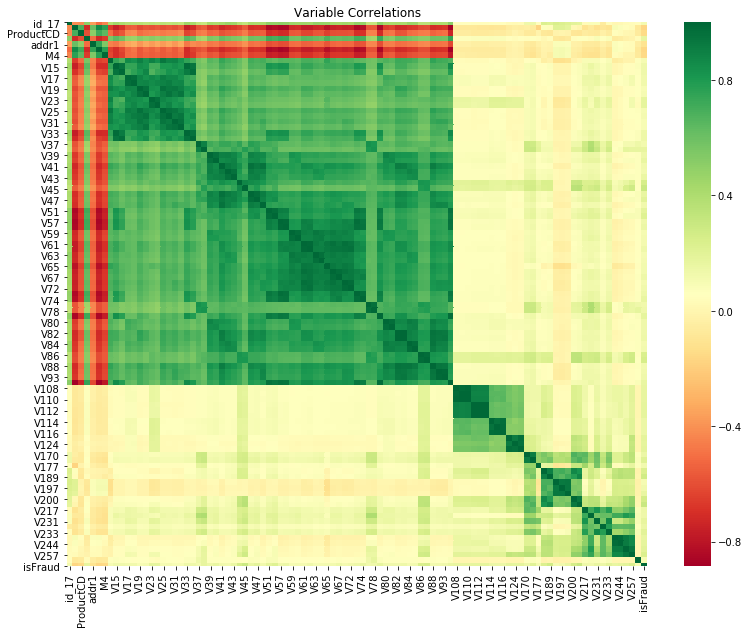

In [61]:
train_corr = train[:50000].copy()
train_corr['isFraud'] = train_target.copy()

corrmat = train_corr.corr()
top_corr_features = corrmat.index[abs(corrmat['isFraud']) >= 0.10]
# top_corr_features
plt.figure(figsize=(13,10))
sns.heatmap(train_corr[top_corr_features].corr(), annot=False, cmap="RdYlGn")
plt.title('Variable Correlations')
plt.show()

In [62]:
train = train.drop('TransactionID', axis=1)
test_tid = test['TransactionID']
test = test.drop('TransactionID', axis=1)

In [64]:
# Standardization
train_scale_ = train.drop(categorical_features, axis=1)
test_scale_ = test.drop(categorical_features, axis=1)

# z = (x - u) / s
train_scale = (train_scale_ - train_scale_.mean()) / train_scale_.std()
test_scale = (test_scale_ - train_scale_.mean()) / train_scale_.std()

In [65]:
train[train_scale.columns] = train_scale
test[test_scale.columns] = test_scale

## LightGBM model

In [89]:
# Split train set / valid set
x_train, x_val, y_train, y_val = train_test_split(train, train_target, random_state=42)

# LightGBM
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(x_val, y_val, categorical_feature=categorical_features)

# parameters
params = {
    'objective':'binary',
    'max_depth': 6,
    'learning_rate': 0.1,
    'boosting_type': 'gbdt'
}

# Training
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                     num_boost_round=1000,
                     early_stopping_rounds=100,
                     verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0739849	valid_1's binary_logloss: 0.0804221
[200]	training's binary_logloss: 0.0644853	valid_1's binary_logloss: 0.0733421
[300]	training's binary_logloss: 0.0586095	valid_1's binary_logloss: 0.0693812
[400]	training's binary_logloss: 0.0537823	valid_1's binary_logloss: 0.0666542
[500]	training's binary_logloss: 0.0496325	valid_1's binary_logloss: 0.0642542
[600]	training's binary_logloss: 0.0459764	valid_1's binary_logloss: 0.0620231
[700]	training's binary_logloss: 0.0427592	valid_1's binary_logloss: 0.0602896
[800]	training's binary_logloss: 0.0402249	valid_1's binary_logloss: 0.0590586
[900]	training's binary_logloss: 0.0376833	valid_1's binary_logloss: 0.0578902
[1000]	training's binary_logloss: 0.0352916	valid_1's binary_logloss: 0.0567794
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0352916	valid_1's binary_logloss: 0.0567794


In [90]:
val_preds = [1 if i>=0.5 else 0 for i in lgb_model.predict(x_val)]

print('Accuracy : {:.2f}'.format(accuracy_score(val_preds, y_val)))
print('Recall : {:.2f}'.format(recall_score(val_preds, y_val)))
print(classification_report(val_preds, y_val))

Accuracy : 0.98
Recall : 0.94
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    144515
           1       0.57      0.94      0.71      3120

    accuracy                           0.98    147635
   macro avg       0.78      0.96      0.85    147635
weighted avg       0.99      0.98      0.99    147635



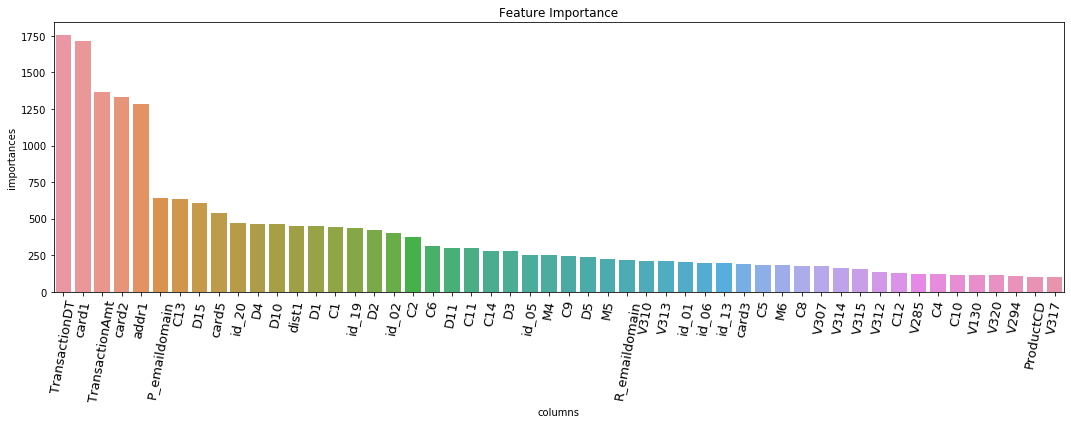

In [92]:
# feature importances
feature_importance = lgb_model.feature_importance()
df_fi = pd.DataFrame({'columns':x_train.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > 100].sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15, 6))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Save Prediction of test to *.csv

In [93]:
test_preds = lgb_model.predict(test)

In [94]:
test_pred_df = pd.DataFrame()
test_pred_df['TransactionID'] = test_tid
test_pred_df['isFraud'] = test_preds

In [95]:
test_pred_df.head(10)

,TransactionID,isFraud
0,3663586,0.117177
1,3663588,0.001558
2,3663597,0.013472
3,3663601,0.005209
4,3663602,0.069560
5,3663622,0.165837
6,3663624,0.061118
7,3663626,0.037178
8,3663629,0.022196
9,3663658,0.000468


In [96]:
test_pred_df.to_csv('lgb_submission.csv', index=False)